In [40]:
#Start of the project
#data preprocessing
#convert data into csv format, also create train set, valid set and test set
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/gdrive/')

DATAPATH = './dataset/FaceMaskDetection/'
IMAGEPATH = os.path.join(DATAPATH, "images") #path linked to the file storing all images
ANNOPATH = os.path.join(DATAPATH, "annotations") #path linked to the file storing all xml

features = {'image_name': [], 'width': [], 'height': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': []} #extracted information of each data

for xml in os.listdir(ANNOPATH):
  info = et.parse(ANNOPATH + '/' + xml)
  root = info.getroot()
  image = root[1].text
  width = root[2][0].text
  height = root[2][1].text
  for i in range(4, len(root)):
    label = root[i][0].text
    #with_mask = 0, without_mask = 1, mask_weared_incorrect = 2
    if label == 'with_mask':
      label = 0
    elif label == 'without_mask':
      label = 1
    elif label == 'mask_weared_incorrect':
      label = 2
    cur_data = []
    cur_data.append(image)
    cur_data.append(width)
    cur_data.append(height)
    for coord in root[i][5]:
      cur_data.append(coord.text)
    cur_data.append(label)
    for i, feature in enumerate(features):
      features[feature].append(cur_data[i])

dataset = pd.DataFrame(features)
target_count = dataset['label'].value_counts()
print('Class 0: ', target_count[0])
print('Class 1: ', target_count[1])
print('Class 2: ', target_count[2])
dataset.to_csv(path_or_buf = DATAPATH + '/preprocessed.csv', index = False)

#start splitting into training set, validation set and test set
features = dataset[['image_name', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']]
labels = dataset['label']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 4471)
train_features, valid_features, train_labels, valid_labels = train_test_split(train_features, train_labels, test_size = 815, random_state = 4471)

train_features.insert(7, 'label', train_labels)
test_features.insert(7, 'label', test_labels)
valid_features.insert(7, 'label', valid_labels)

train = train_features
test = test_features
valid = valid_features

print(train)
print()
print(test)
print()
print(valid)
print()

train.to_csv(path_or_buf = DATAPATH + '/train.csv', index = False)
test.to_csv(path_or_buf = DATAPATH + '/test.csv', index = False)
valid.to_csv(path_or_buf = DATAPATH + '/valid.csv', index = False)

Class 0:  3232
Class 1:  717
Class 2:  123
               image_name width height xmin ymin xmax ymax  label
1253  maksssksksss329.png   400    267   50  121   89  158      0
53     maksssksksss11.png   400    267  275   99  303  128      0
3039  maksssksksss661.png   400    261  266   84  290  112      0
1170  maksssksksss310.png   400    267   21   32   44   59      0
2067  maksssksksss498.png   400    272  355   67  375   90      0
...                   ...   ...    ...  ...  ...  ...  ...    ...
2978  maksssksksss648.png   400    267  117   73  136   99      0
3731  maksssksksss795.png   400    300  181   67  208   95      0
3986   maksssksksss86.png   400    300   22  121   77  181      0
111   maksssksksss115.png   400    267  137   88  159  110      0
646   maksssksksss234.png   400    225    3   72   12   89      0

[2442 rows x 8 columns]

               image_name width height xmin ymin xmax ymax  label
1739  maksssksksss428.png   400    267  180   56  191   68      0
929   m

In [195]:
%autosave 5
#num of sample per class in train
for x in range(3):
    print(len(train[train['label'] == x]), end=', ') 

Autosaving every 5 seconds
1928, 447, 67, 

In [2]:
#create dataset class
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader


class ImageDataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.df = pd.read_csv(csv_file)      
        self.transform = transform

    def __getitem__(self, idx):
        image = self.df['image_name'][idx]
        label = self.df['label'][idx]
        
        image = Image.open(IMAGEPATH + '/' + image)
        image = image.convert('RGB') #3 channels

        (left, upper, right, lower) = (int(self.df['xmin'][idx]), int(self.df['ymin'][idx]), int(self.df['xmax'][idx]), int(self.df['ymax'][idx])) #coordinate of bounding box
        image = image.crop((left, upper, right, lower)) #the cropped image, which is the face

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.df)

In [103]:
class AugImageDataset(Dataset):
    def __init__(self, csv_file, transform = None, augs = None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.augs = augs

    def __getitem__(self, idx):
        og_idx = idx
        idx = idx%len(self.df)
        
        image = self.df['image_name'][idx]
        label = self.df['label'][idx]
        
        image = Image.open(IMAGEPATH + '/' + image)
        image = image.convert('RGB') #3 channels

        #beware aug is done BEFORE crop
        if self.augs is not None and og_idx >= len(self.df):
            aug_idx = int(og_idx / len(self.df)) - 1
            image = self.augs[aug_idx].forward(image)
        
        (left, upper, right, lower) = (int(self.df['xmin'][idx]), int(self.df['ymin'][idx]), int(self.df['xmax'][idx]), int(self.df['ymax'][idx])) #coordinate of bounding box
        image = image.crop((left, upper, right, lower)) #the cropped image, which is the face
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        if self.augs is not None:
            return len(self.df)*(len(self.augs) + 1)
        return len(self.df)

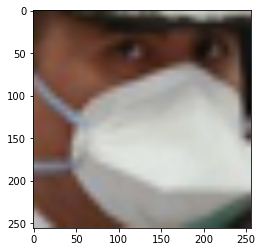

In [122]:
#Observe the result with bilinear interpolation
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize([256,256])])
trial = ImageDataset(DATAPATH + '/train.csv', transform)
plt.imshow(trial[0][0])

In [ ]:
#ideas https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
#save flip, scale and rotate for later, #could also try auto aug

size after aug 9768


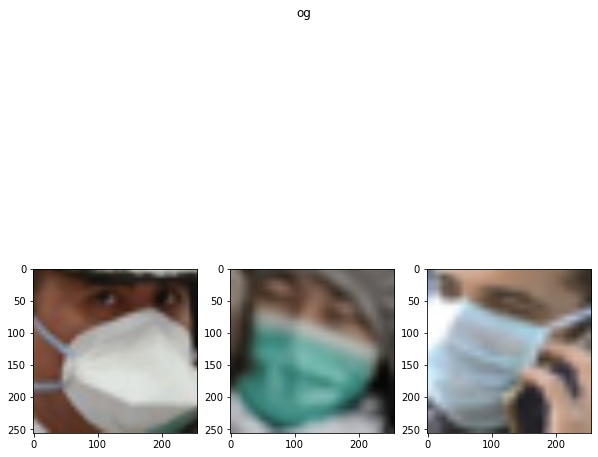

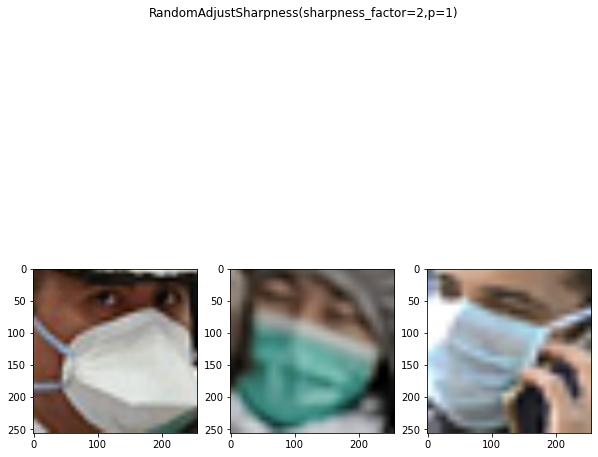

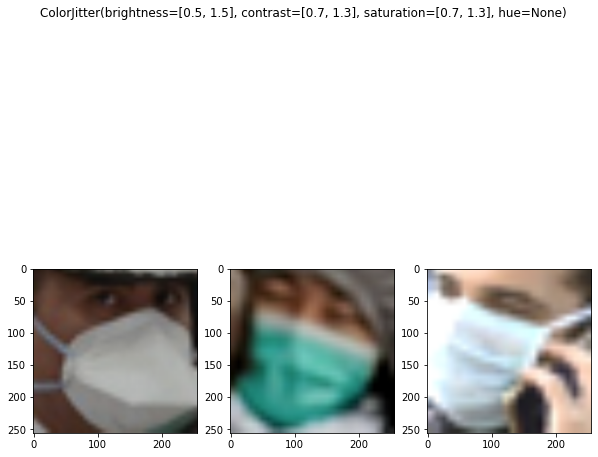

In [193]:
augmentations = [transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                 transforms.RandomAdjustSharpness(2, p=1),
                 transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3)]
augtrainset = AugImageDataset(DATAPATH + '/train.csv', transform, augmentations)
print('size after aug', len(augtrainset))

#visualize augmentations
show_count = len(augmentations) + 1
num = 3
for i in range(show_count):
    if i in [1]:
        continue
    fig, axis = plt.subplots(ncols=num, figsize=(10, 10))
    fig.suptitle((['og'] + augmentations)[i])
    for j in range(num):
        axis[j].imshow(augtrainset[i*len(augtrainset.df)+j][0])

In [196]:
#create dataset and dataloader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([256, 256]), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # resize to 256 x 256

trainset = augtrainset
validset = ImageDataset(DATAPATH + '/valid.csv', transform)
testset = ImageDataset(DATAPATH + '/test.csv', transform)

bs = 16

train_loader = DataLoader(trainset, batch_size = bs, shuffle = True)
valid_loader = DataLoader(validset, batch_size = bs, shuffle = False)
test_loader = DataLoader(testset, batch_size = bs, shuffle = False)

In [5]:
#Apply Transfer Learning, Build a ResNet152 pretrained with ImageNet
!pip install torchsummaryX
import torchvision.models as models
import torch.nn as nn
from torchsummaryX import summary
resnet152 = models.resnet152(pretrained = True)
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 3)

summary(resnet152, torch.zeros((1, 3, 256, 256)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


                                             Kernel Shape       Output Shape  \
Layer                                                                          
0_conv1                                     [3, 64, 7, 7]  [1, 64, 128, 128]   
1_bn1                                                [64]  [1, 64, 128, 128]   
2_relu                                                  -  [1, 64, 128, 128]   
3_maxpool                                               -    [1, 64, 64, 64]   
4_layer1.0.Conv2d_conv1                    [64, 64, 1, 1]    [1, 64, 64, 64]   
5_layer1.0.BatchNorm2d_bn1                           [64]    [1, 64, 64, 64]   
6_layer1.0.ReLU_relu                                    -    [1, 64, 64, 64]   
7_layer1.0.Conv2d_conv2                    [64, 64, 3, 3]    [1, 64, 64, 64]   
8_layer1.0.BatchNorm2d_bn2                           [64]    [1, 64, 64, 64]   
9_layer1.0.ReLU_relu                                    -    [1, 64, 64, 64]   
10_layer1.0.Conv2d_conv3                

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[3, 64, 7, 7]","[1, 64, 128, 128]",9408.0,154140672.0
1_bn1,[64],"[1, 64, 128, 128]",128.0,64.0
2_relu,-,"[1, 64, 128, 128]",NaN,NaN
3_maxpool,-,"[1, 64, 64, 64]",NaN,NaN
4_layer1.0.Conv2d_conv1,"[64, 64, 1, 1]","[1, 64, 64, 64]",4096.0,16777216.0
...,...,...,...,...
459_layer4.2.Conv2d_conv3,"[512, 2048, 1, 1]","[1, 2048, 8, 8]",1048576.0,67108864.0
460_layer4.2.BatchNorm2d_bn3,[2048],"[1, 2048, 8, 8]",4096.0,2048.0
461_layer4.2.ReLU_relu,-,"[1, 2048, 8, 8]",NaN,NaN


In [6]:
#function for saving the checkpoint of the model
def save_checkpoint(save_path, net, optimizer, val_loss):
    if save_path == None:
      return

    save_path = save_path 
    state_dict = {'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
            }

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

In [7]:
#function for loading the saved checkpoint of the model
#comment out relevant part if do not want to load saved checkpoint
def load_checkpoint(save_path, net, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    net.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}')
    return val_loss

In [8]:
#Train function
def TRAIN(net, train_loader, valid_loader, num_epochs, criterion, optimizer, train_loss_plot, valid_loss_plot, train_epoch_plot, valid_epoch_plot, weighted_loss = None, val_loss = None, save_name = None):
  
  if val_loss == None:
    best_val_loss = float("Inf")  
  else: 
    best_val_loss = val_loss
    print('Resume training')


  for epoch in range(num_epochs):
    net.train()
    train_running_loss = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = net(images) # forward()
    
      if weighted_loss is not None:
        weights = torch.cuda.FloatTensor(weighted_loss)
        criterion = nn.CrossEntropyLoss(weight = weights)

      loss = criterion(outputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.LongTensor))
      
      optimizer.zero_grad()  
      loss.backward()
      optimizer.step() 

      train_running_loss += loss.item()
      avg_train_running_loss = train_running_loss / float(len(train_loader))

    
    # validation
    with torch.no_grad():
      net.eval()
      val_running_loss = 0
      running_corrects = 0
      for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images) # forward()

        if weighted_loss is not None:
          weights = torch.cuda.FloatTensor(weighted_loss)
          criterion = nn.CrossEntropyLoss(weight = weights)

        loss = criterion(outputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.LongTensor))

        outputs = torch.log_softmax(outputs, dim = 1)
        _, outputs = torch.max(outputs, dim = 1)

        val_running_loss += loss.item()
        avg_val_running_loss = val_running_loss / float(len(valid_loader))


        running_corrects += torch.sum(outputs.data == labels.data)

      valid_acc = running_corrects / float(len(valid_loader.dataset))

    train_epoch_plot.append(epoch)
    valid_epoch_plot.append(epoch)
    train_loss_plot.append(avg_train_running_loss)
    valid_loss_plot.append(avg_val_running_loss)
    print(f'Epoch {epoch} Training_Loss {avg_train_running_loss} Validation_Loss {avg_val_running_loss} Valid_Acc {valid_acc} Running_corrects {running_corrects}')

    if avg_val_running_loss < best_val_loss:
      if save_name is not None:
        best_val_loss = avg_val_running_loss
        save_checkpoint(save_name, net, optimizer, best_val_loss)

cuda
Epoch 0 Training_Loss 0.3743983411954509 Validation_Loss 0.44672121341321985 Valid_Acc 0.8625766634941101 Running_corrects 703
Model saved to gdrive/My Drive/Project1/dataset/resnet152.pt
Epoch 1 Training_Loss 0.27802331197787733 Validation_Loss 0.3891117196603149 Valid_Acc 0.9190183877944946 Running_corrects 749
Model saved to gdrive/My Drive/Project1/dataset/resnet152.pt
Epoch 2 Training_Loss 0.27680961059686404 Validation_Loss 0.40640389422575635 Valid_Acc 0.8748466372489929 Running_corrects 713
Epoch 3 Training_Loss 0.25800281851948087 Validation_Loss 0.33717789924612235 Valid_Acc 0.9092024564743042 Running_corrects 741
Model saved to gdrive/My Drive/Project1/dataset/resnet152.pt
Epoch 4 Training_Loss 0.24135063005477383 Validation_Loss 0.2077837693413683 Valid_Acc 0.9411042928695679 Running_corrects 767
Model saved to gdrive/My Drive/Project1/dataset/resnet152.pt
Epoch 5 Training_Loss 0.21500471113188788 Validation_Loss 0.6499767783006617 Valid_Acc 0.89570552110672 Running_co

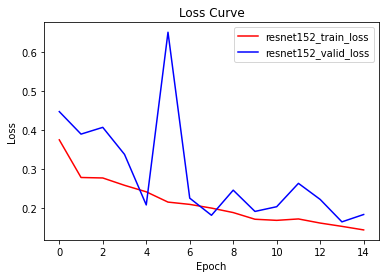

In [9]:
#start training resnet152
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
renset152 = resnet152.to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 15
optimizer = optim.Adam(resnet152.parameters())
train_epoch_plot_resnet152 = []
valid_epoch_plot_resnet152 = []
train_loss_plot_resnet152 = []
valid_loss_plot_resnet152 = []

TRAIN(resnet152, train_loader, valid_loader, num_epochs, criterion, optimizer, train_loss_plot_resnet152, valid_loss_plot_resnet152, train_epoch_plot_resnet152, valid_epoch_plot_resnet152, save_name = DATAPATH + '/resnet152.pt')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_epoch_plot_resnet152, train_loss_plot_resnet152, color = 'red', label = 'resnet152_train_loss')
plt.plot(valid_epoch_plot_resnet152, valid_loss_plot_resnet152, color = 'blue', label = 'resnet152_valid_loss')
plt.legend()

In [11]:
#Prediction function
def predict(net, t_loader, read_csv_path, write_csv_path):
  net.eval()
  p1 = pd.read_csv(read_csv_path)
  predict_labels = []

  with torch.no_grad():
    for images, labels in t_loader:
      images, labels = images.to(device), labels.to(device)
      net.eval()
 
      outputs = net(images) # forward()
      outputs = torch.log_softmax(outputs, dim = 1)
      _, outputs = torch.max(outputs, dim = 1)

      for output in outputs:
        output = output.cpu().detach().numpy()
        predict_labels.append(output)
        

  p1 = p1.drop(columns=['label'], axis = 1)
  p1.insert(7, 'label', predict_labels)
  p1.to_csv(write_csv_path, index = False)

In [12]:
#check prediction accuracy function
def check_acc(test_csv_path, predicted_csv_path):
  test = pd.read_csv(test_csv_path)
  predicted = pd.read_csv(predicted_csv_path)

  correct = 0

  for i in range(len(predicted)):
    if test['label'][i] == predicted['label'][i]:
      correct += 1

  print(correct)

  print('accuracy: ', correct / len(predicted))

In [16]:
#print classification report function
from sklearn.metrics import classification_report
def print_report(test_csv_path, predicted_csv_path):
  labels = pd.read_csv(test_csv_path)['label']
  predicted = pd.read_csv(predicted_csv_path)['label']
  target_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']
  print(classification_report(labels, predicted, target_names = target_names))

In [17]:
predict(resnet152, test_loader, DATAPATH + '/test.csv', DATAPATH + '/predict.csv')
check_acc(DATAPATH + '/test.csv', DATAPATH + '/predict.csv')
print_report(DATAPATH + '/test.csv', DATAPATH + '/predict.csv')

767
accuracy:  0.9411042944785276
                       precision    recall  f1-score   support

            with_mask       0.95      0.98      0.97       660
         without_mask       0.89      0.94      0.91       127
mask_weared_incorrect       0.00      0.00      0.00        28

             accuracy                           0.94       815
            macro avg       0.61      0.64      0.63       815
         weighted avg       0.91      0.94      0.93       815

